In [1]:
import jax
print(f"JAX devices: {jax.devices()}")
print(f"Backend: {jax.default_backend()}")
assert jax.default_backend() == "gpu", "gpu not detected!"


JAX devices: [CudaDevice(id=0)]
Backend: gpu


In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad
import jax
import os

import jaxley as jx
import jaxley.optimize.transforms as jt
from jaxley.channels import Na, K, Leak
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import connect

import optax
import time as _time

In [3]:
n_post_comp = 15
num_pre = 8
post_idx = num_pre          # post cell index inside the network
Nsyn = num_pre

i_delay = 3.0    # ms
i_amp = 0.05   # nA
i_dur = 2.0    # ms
dt = 0.025  # ms
t_max = 50.0   # ms

base_amp = i_amp

syn_post_comp_indices = np.linspace(0, n_post_comp - 1, num_pre).astype(int)
# [0, 2, 4, 6, 8, 10, 12, 14]

def build_net():
    _comp_pre = jx.Compartment()
    _branch_pre = jx.Branch(_comp_pre, ncomp=1)
    _cell_pre = jx.Cell(_branch_pre, parents=np.asarray([-1]))

    _comp_post = jx.Compartment()
    _branch_post = jx.Branch(_comp_post, ncomp=n_post_comp)
    _cell_post = jx.Cell(_branch_post, parents=np.asarray([-1]))

    _cells = [_cell_pre for _ in range(num_pre)] + [_cell_post]
    _net = jx.Network(_cells)

    _net.insert(Na())
    _net.insert(K())
    _net.insert(Leak())

    _syn = IonotropicSynapse()
    for pre_i, comp_i in zip(range(num_pre), syn_post_comp_indices):
        connect(
            _net.cell(pre_i).branch(0).comp(0),
            _net.cell(post_idx).branch(0).comp(int(comp_i)),
            _syn,
        )
    return _net

def setup_recordings(net_obj):
    net_obj.delete_recordings()
    net_obj.cell(post_idx).branch(0).comp(0).record()          # syn 0 = soma
    for ci in syn_post_comp_indices:
        if int(ci) != 0:
            net_obj.cell(post_idx).branch(0).comp(int(ci)).record()
    return net_obj

net_analysis = build_net()
net_analysis = setup_recordings(net_analysis)
net_analysis.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")
print(f"Network: {net_analysis.nodes.shape[0]} compartments, "
      f"{net_analysis.edges.shape[0]} edges")
print(f"Nsyn = {Nsyn}, syn_post_comp_indices = {syn_post_comp_indices}")



Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Number of newly added trainable parameters: 8. Total number of trainable parameters: 8
Network: 23 compartments, 8 edges
Nsyn = 8, syn_post_comp_indices = [ 0  2  4  6  8 10 12 14]


In [4]:
params_true = net_analysis.get_parameters()

In [5]:
def simulate_analysis(params_phys, pattern):
    amps = base_amp * pattern
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay, i_dur=i_dur,
        i_amp=amps, delta_t=dt, t_max=t_max,
    )
    net_analysis.delete_stimuli()
    data_stimuli = None
    for i in range(num_pre):
        data_stimuli = (
            net_analysis.cell(i).branch(0).loc(0.0)
            .data_stimulate(currents[i], data_stimuli=data_stimuli)
        )
    traces = jx.integrate(
        net_analysis, params=params_phys,
        data_stimuli=data_stimuli, delta_t=dt,
    )
    return traces                         # (Nsyn, T)

def loss_and_traces(params_phys, pattern, target):
    raw_traces = simulate_analysis(params_phys, pattern)
    soma_pred  = raw_traces[0]
    loss = jnp.mean((soma_pred - target) ** 2)
    return loss, raw_traces

_vg_fn = jax.value_and_grad(loss_and_traces, argnums=0, has_aux=True)

def single_trial(params_phys, pattern, target):
    (loss, raw_traces), grads = _vg_fn(params_phys, pattern, target)
    grad_w = grads[0]["IonotropicSynapse_gS"]       # (Nsyn,)
    return grad_w, raw_traces, loss

# batched over patterns (shared params)
batched_vg = jit(jax.vmap(
    jax.value_and_grad(loss_and_traces, argnums=0, has_aux=True),
    in_axes=(None, 0, 0),
))

# patterns_onehot = jnp.eye(Nsyn, dtype=jnp.float64)

# targets_onehot = []
# for p in range(Nsyn):
#     soma = simulate_analysis(params_true, patterns_onehot[p])[0]  # soma trace
#     targets_onehot.append(soma)
# targets_onehot = jnp.stack(targets_onehot, axis=0)

def simulate_soma(params_phys, pattern):
    return simulate_analysis(params_phys, pattern)[0]   # (T,)

batched_simulate_soma = jit(vmap(simulate_soma, in_axes=(None, 0)))
# def simulate_soma_batch(params_phys, patterns):
#     somas = []
#     for p in range(patterns.shape[0]):
#         somas.append(simulate_analysis(params_phys, patterns[p])[0])
#     return jnp.stack(somas, axis=0)  # (P, T)

# targets_onehot = simulate_soma_batch(params_true, patterns_onehot)


In [6]:
gS_true = params_true[0]["IonotropicSynapse_gS"]
params_true = [{"IonotropicSynapse_gS": gS_true}]
transform = jx.ParamTransform([
    {"IonotropicSynapse_gS": jt.SigmoidTransform(1e-5, 1e-2)},
])
opt_params_true = transform.inverse(params_true)
key_learn = jax.random.PRNGKey(1)
# noise_scale = 0.5

# def add_noise_to_opt_params(opt_params, key, scale):
#     leaves, treedef = jax.tree_util.tree_flatten(opt_params)
#     subkeys = jax.random.split(key, len(leaves))
#     noisy_leaves = [
#         p + scale * jax.random.normal(k, p.shape)
#         for p, k in zip(leaves, subkeys)
#     ]
#     return jax.tree_util.tree_unflatten(treedef, noisy_leaves)

# opt_params_learn = add_noise_to_opt_params(opt_params_true, key_learn, noise_scale)
# params_analysis = transform.forward(opt_params_learn)
key_learn = jax.random.PRNGKey(1)
sigma = 0.05  # 5% lognormal perturbation
gS_learned = jnp.clip(
    gS_true * jnp.exp(sigma * jax.random.normal(key_learn, (Nsyn,))),
    1e-5, 1e-2
)
params_analysis = [{"IonotropicSynapse_gS": gS_learned}]
gS_learned = params_analysis[0]["IonotropicSynapse_gS"]

print("gS_true:", gS_true)
print("gS_learned:", gS_learned)
print(f"max |diff|: {float(jnp.max(jnp.abs(gS_true - gS_learned))):.2e}")

patterns_onehot = jnp.eye(Nsyn, dtype=jnp.float64)   # (8, 8)
print(f"\npatterns_onehot shape: {patterns_onehot.shape}")
print(patterns_onehot)

targets_onehot = batched_simulate_soma(params_true, patterns_onehot)   # (8, T)
T = targets_onehot.shape[1]
t_arr = np.arange(T) * dt                                              # time axis

print(f"\ntargets_onehot shape: {targets_onehot.shape}")
print(f"T = {T},  dt = {dt} ms,  t_max = {t_max} ms")


gS_true: [0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001]
gS_learned: [9.42504843e-05 9.94208316e-05 1.00867190e-04 1.04902940e-04
 9.59207643e-05 1.03514370e-04 1.00377964e-04 9.62495051e-05]
max |diff|: 5.75e-06

patterns_onehot shape: (8, 8)
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]

targets_onehot shape: (8, 2002)
T = 2002,  dt = 0.025 ms,  t_max = 50.0 ms


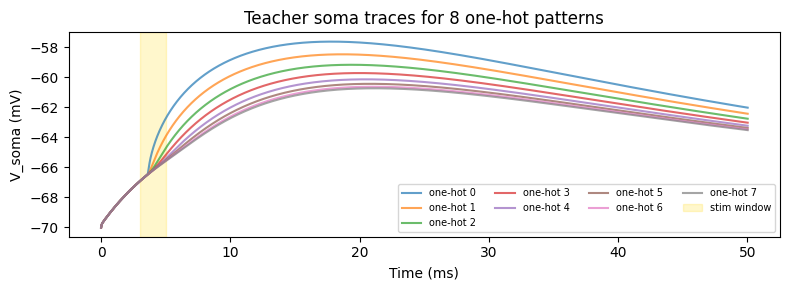

In [7]:
fig, ax = plt.subplots(figsize=(8, 3))
for p in range(Nsyn):
    ax.plot(t_arr, targets_onehot[p], alpha=0.7, label=f"one-hot {p}")
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.2, label="stim window")
ax.set_xlabel("Time (ms)"); ax.set_ylabel("V_soma (mV)")
ax.set_title("Teacher soma traces for 8 one-hot patterns")
ax.legend(fontsize=7, ncol=4)
plt.tight_layout(); plt.show()

In [19]:
patterns_train = patterns_onehot          # (8, 8) — identity matrix
targets_train = targets_onehot           # (8, T) — teacher soma traces
N_train = patterns_train.shape[0]         # 8

print(f"Training set: {N_train} one-hot patterns × {Nsyn} synapses")
print(f"patterns_train shape: {patterns_train.shape}")
print(f"targets_train shape: {targets_train.shape}")
print(f"Target V range: [{float(targets_train.min()):.2f}, "
      f"{float(targets_train.max()):.2f}] mV")
print(f"\nPatterns (each row activates exactly 1 synapse):")
print(np.asarray(patterns_train))


Training set: 8 one-hot patterns × 8 synapses
patterns_train shape: (8, 8)
targets_train shape: (8, 2002)
Target V range: [-70.00, -57.62] mV

Patterns (each row activates exactly 1 synapse):
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [ ]:
net_train = build_net()
net_train.delete_recordings()
net_train.cell(post_idx).branch(0).comp(0).record() # soma only
net_train.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")

train_transform = jx.ParamTransform([
    {"IonotropicSynapse_gS": jt.SigmoidTransform(1e-5, 1e-2)},
])


def _sim_soma_train(params_phys, pattern):
    amps = base_amp * pattern
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay, i_dur=i_dur, i_amp=amps, delta_t=dt, t_max=t_max,
    )
    net_train.delete_stimuli()
    data_stimuli = None
    for i in range(num_pre):
        data_stimuli = (
            net_train.cell(i).branch(0).loc(0.0)
            .data_stimulate(currents[i], data_stimuli=data_stimuli)
        )
    traces = jx.integrate(
        net_train, params=params_phys,
        data_stimuli=data_stimuli, delta_t=dt,
    )
    return traces[0]                                          # (T,)

_batched_soma_train = vmap(_sim_soma_train, in_axes=(None, 0))

def _train_loss_batch(opt_params, pats, tgts):
    params_phys = train_transform.forward(opt_params)
    preds = _batched_soma_train(params_phys, pats)            # (B, T)
    return jnp.mean((preds - tgts) ** 2)

train_lr = 0.05
train_optimizer = optax.adam(train_lr)

@jit
def _train_step(opt_params, opt_state, pats, tgts):
    loss, grads = jax.value_and_grad(_train_loss_batch)(
        opt_params, pats, tgts,
    )
    updates, new_state = train_optimizer.update(grads, opt_state, opt_params)
    new_params = optax.apply_updates(opt_params, updates)
    return new_params, new_state, loss

checkpoints = [10, 25, 50]
n_steps_train = max(checkpoints)   # 50

def train_one_seed(seed, patterns_train, targets_train,
                   n_steps=50, checkpoints=(10, 25, 50), log_every=5):
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)
    gS0 = jnp.clip(
        1e-4 * jnp.exp(0.05 * jax.random.normal(subkey, (Nsyn,))),
        1e-5, 1e-2,
    )
    params0 = [{"IonotropicSynapse_gS": gS0}]
    opt_params = train_transform.inverse(params0)
    opt_state = train_optimizer.init(opt_params)

    # # pick one pattern
    # p = patterns_train[0]

    # # run twice using the *same* params_phys
    # params_phys0 = train_transform.forward(opt_params)
    # v1 = _sim_soma_train(params_phys0, p)
    # v2 = _sim_soma_train(params_phys0, p)

    # print("repeat max diff:", float(jnp.max(jnp.abs(v1 - v2))))

    loss_log = []
    checkpoint_params = {}      # {step: params_phys}
    ckpt_set = set(checkpoints)

    for step in range(1, n_steps + 1):
        opt_params, opt_state, loss = _train_step(
            opt_params, opt_state, patterns_train, targets_train,
        )

        if step % log_every == 0 or step == n_steps:
            loss_log.append((step, float(loss)))

        if step in ckpt_set:
            checkpoint_params[step] = train_transform.forward(opt_params)

    return checkpoint_params, {"losses": loss_log, "final_loss": float(loss)}


print(f"Sanity check: training seed=0 ({n_steps_train} steps, "
      f"checkpoints at {checkpoints}) ...")
_t0 = _time.time()
_ckpt0, _log0 = train_one_seed(0, patterns_train, targets_train)
_t1 = _time.time()
print(f"  Time: {_t1-_t0:.1f}s")
print(f"  Init loss:  {_log0['losses'][0][1]:.4f}")
print(f"  Final loss: {_log0['final_loss']:.4f}")
for _c in sorted(_ckpt0):
    _gS_c = np.asarray(_ckpt0[_c][0]["IonotropicSynapse_gS"])
    print(f"  gS @ step {_c:3d}: {_gS_c}  "
          f"(max |diff| from true = {np.abs(_gS_c - np.asarray(gS_true)).max():.2e})")


Added 1 recordings. See `.recordings` for details.
Number of newly added trainable parameters: 8. Total number of trainable parameters: 8
Sanity check: training seed=0 (50 steps, checkpoints at [10, 25, 50]) ...
repeat max diff: 0.0
  Time: 59.9s
  Init loss:  0.0213
  Final loss: 0.0003
  gS @ step  10: [1.02766647e-04 9.62647625e-05 9.81334491e-05 9.87931771e-05
 9.86285640e-05 9.83741626e-05 9.82532119e-05 9.82561841e-05]  (max |diff| from true = 3.74e-06)
  gS @ step  25: [9.79823938e-05 1.01609265e-04 1.00646957e-04 1.00368462e-04
 1.00504216e-04 1.00509691e-04 1.00303988e-04 9.99517584e-05]  (max |diff| from true = 2.02e-06)
  gS @ step  50: [9.95180380e-05 1.00543370e-04 1.00275959e-04 1.00269072e-04
 1.00281067e-04 1.00167167e-04 1.00050205e-04 9.99851478e-05]  (max |diff| from true = 5.43e-07)


In [31]:
# ── Sanity check: vmap vs loop (should match) ─────────────────────────
seed = 0
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key)

gS0 = jnp.clip(
    1e-4 * jnp.exp(0.05 * jax.random.normal(subkey, (Nsyn,))),
    1e-5, 1e-2,
)
params0 = [{"IonotropicSynapse_gS": gS0}]
opt_params0 = train_transform.inverse(params0)
params_phys0 = train_transform.forward(opt_params0)

pats = patterns_train[:4]  # small batch

pred_vmap = _batched_soma_train(params_phys0, pats)  # (4, T)
pred_loop = jnp.stack(
    [_sim_soma_train(params_phys0, pats[i]) for i in range(pats.shape[0])],
    axis=0
)

print("vmap-loop max diff:", float(jnp.max(jnp.abs(pred_vmap - pred_loop))))


vmap-loop max diff: 0.0


In [21]:
# ══════════════════════════════════════════════════════════════════════
# Train S seeds × 50 steps, save & evaluate at checkpoints [10, 25, 50]
# ══════════════════════════════════════════════════════════════════════
S = 25

# Per-checkpoint storage
gS_ckpt   = {c: np.zeros((S, Nsyn))           for c in checkpoints}  # (S,8)
GRADS_ckpt = {c: np.zeros((S, Nsyn, Nsyn))    for c in checkpoints}  # (S,8,8)
VALL_ckpt  = {c: np.zeros((S, Nsyn, Nsyn, T)) for c in checkpoints}  # (S,8,8,T)
LOSS_ckpt  = {c: np.zeros((S, Nsyn))           for c in checkpoints}  # (S,8)
train_logs_all = []

print(f"Training {S} seeds × {n_steps_train} steps  "
      f"(full-batch on {N_train} one-hots, lr={train_lr})")
print(f"Checkpoints: {checkpoints}")
print(f"Per-checkpoint shapes:  GRADS (S,8,8)  VALL (S,8,8,{T})  LOSS (S,8)\n")

t_start = _time.time()

for s in range(S):
    t_seed = _time.time()

    # ── Train ────────────────────────────────────────────────────────
    ckpt_params_s, log_s = train_one_seed(
        seed=s, patterns_train=patterns_train,
        targets_train=targets_train,
    )
    train_logs_all.append(log_s)

    # ── Evaluate each checkpoint on 8 one-hot probes ─────────────────
    for c in checkpoints:
        params_c = ckpt_params_s[c]
        gS_ckpt[c][s] = np.asarray(params_c[0]["IonotropicSynapse_gS"])

        ((losses_c, traces_c), grads_c) = batched_vg(
            params_c, patterns_onehot, targets_onehot,
        )
        GRADS_ckpt[c][s] = np.asarray(grads_c[0]["IonotropicSynapse_gS"])  # (8,8)
        VALL_ckpt[c][s]  = np.asarray(traces_c)                            # (8,8,T)
        LOSS_ckpt[c][s]  = np.asarray(losses_c)                            # (8,)

    dt_seed = _time.time() - t_seed
    if s % 5 == 0 or s == S - 1:
        losses_str = "  ".join(
            f"step{c}={log_s['final_loss'] if c == checkpoints[-1] else float(LOSS_ckpt[c][s].mean()):.4f}"
            for c in checkpoints
        )
        print(f"  seed {s:3d}/{S}  {losses_str}  ({dt_seed:.1f}s)")

elapsed = _time.time() - t_start
print(f"\nDone: {S} seeds in {elapsed:.1f}s  ({elapsed / S:.1f}s per seed)")
print(f"Train final-loss range: "
      f"[{min(l['final_loss'] for l in train_logs_all):.4f}, "
      f"{max(l['final_loss'] for l in train_logs_all):.4f}]")

# ── Quick per-checkpoint summary ─────────────────────────────────────
print(f"\nPer-checkpoint probe loss (mean across seeds & patterns):")
for c in checkpoints:
    print(f"  step {c:3d}:  mean loss = {LOSS_ckpt[c].mean():.6f}  "
          f"  gS spread (std) = {gS_ckpt[c].std(axis=0).mean():.2e}")


Training 25 seeds × 50 steps  (full-batch on 8 one-hots, lr=0.05)
Checkpoints: [10, 25, 50]
Per-checkpoint shapes:  GRADS (S,8,8)  VALL (S,8,8,2002)  LOSS (S,8)

  seed   0/25  step10=0.0108  step25=0.0013  step50=0.0003  (47.9s)
  seed   5/25  step10=0.0189  step25=0.0049  step50=0.0002  (39.8s)
  seed  10/25  step10=0.0092  step25=0.0017  step50=0.0000  (39.9s)
  seed  15/25  step10=0.0055  step25=0.0008  step50=0.0000  (39.8s)
  seed  20/25  step10=0.0127  step25=0.0023  step50=0.0001  (39.9s)
  seed  24/25  step10=0.0016  step25=0.0004  step50=0.0000  (39.9s)

Done: 25 seeds in 1004.6s  (40.2s per seed)
Train final-loss range: [0.0000, 0.0007]

Per-checkpoint probe loss (mean across seeds & patterns):
  step  10:  mean loss = 0.011245    gS spread (std) = 1.61e-06
  step  25:  mean loss = 0.002028    gS spread (std) = 8.28e-07
  step  50:  mean loss = 0.000155    gS spread (std) = 2.44e-07


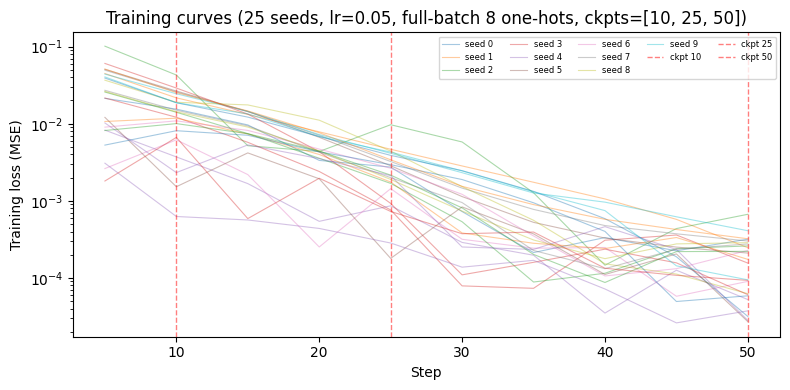

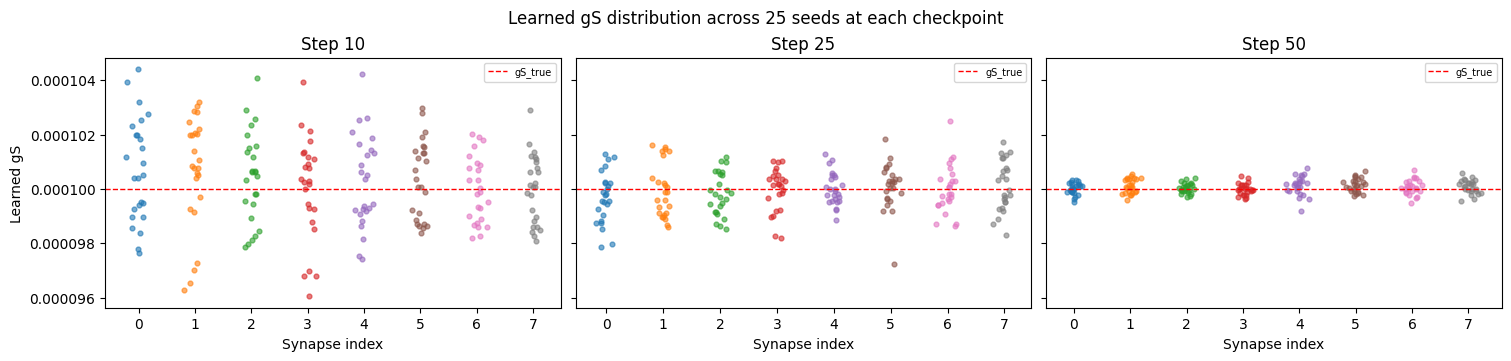

In [22]:
# ── Training loss curves ──────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 4))
for s_i, log_s in enumerate(train_logs_all):
    steps, losses = zip(*log_s["losses"])
    ax.plot(steps, losses, alpha=0.4, lw=0.8,
            label=f"seed {s_i}" if s_i < 10 else None)
# mark checkpoints
for c in checkpoints:
    ax.axvline(c, color="red", ls="--", lw=1, alpha=0.5,
               label=f"ckpt {c}" if c == checkpoints[0] else f"ckpt {c}")
ax.set_xlabel("Step"); ax.set_ylabel("Training loss (MSE)")
ax.set_title(f"Training curves ({S} seeds, lr={train_lr}, "
             f"full-batch {N_train} one-hots, ckpts={checkpoints})")
ax.set_yscale("log")
ax.legend(fontsize=6, ncol=5)
plt.tight_layout(); plt.show()

# ── Learned gS at each checkpoint ────────────────────────────────────
n_ckpt = len(checkpoints)
fig, axes = plt.subplots(1, n_ckpt, figsize=(5 * n_ckpt, 3.5),
                         sharey=True, constrained_layout=True)
for ci, c in enumerate(checkpoints):
    ax = axes[ci]
    for i in range(Nsyn):
        ax.scatter(np.full(S, i) + 0.08 * np.random.randn(S),
                   gS_ckpt[c][:, i], s=12, alpha=0.6)
    ax.axhline(float(gS_true[0]), color="red", ls="--", lw=1, label="gS_true")
    ax.set_xlabel("Synapse index")
    if ci == 0:
        ax.set_ylabel("Learned gS")
    ax.set_title(f"Step {c}")
    ax.legend(fontsize=7)
fig.suptitle(f"Learned gS distribution across {S} seeds at each checkpoint",
             fontsize=12)
plt.show()

In [30]:
# after training and getting params at a checkpoint
params_c = _ckpt0[10]  # or 25/50
((losses_c, traces_c), grads_c) = batched_vg(params_c, patterns_onehot, targets_onehot)
G = np.asarray(grads_c[0]["IonotropicSynapse_gS"])  # (8,8)
print("mean |grad|:", np.mean(np.abs(G)))
print("diag mean |grad|:", np.mean(np.abs(np.diag(G))))
print("off mean |grad|:", np.mean(np.abs(G - np.diag(np.diag(G)))))


mean |grad|: 1933.980718502196
diag mean |grad|: 6224.004291946741
off mean |grad|: 1155.9801820088533


  step  10: R shape (8, 8, 8, 2002), peak diag r = 0.9998
  step  25: R shape (8, 8, 8, 2002), peak diag r = 0.9995
  step  50: R shape (8, 8, 8, 2002), peak diag r = 0.9990


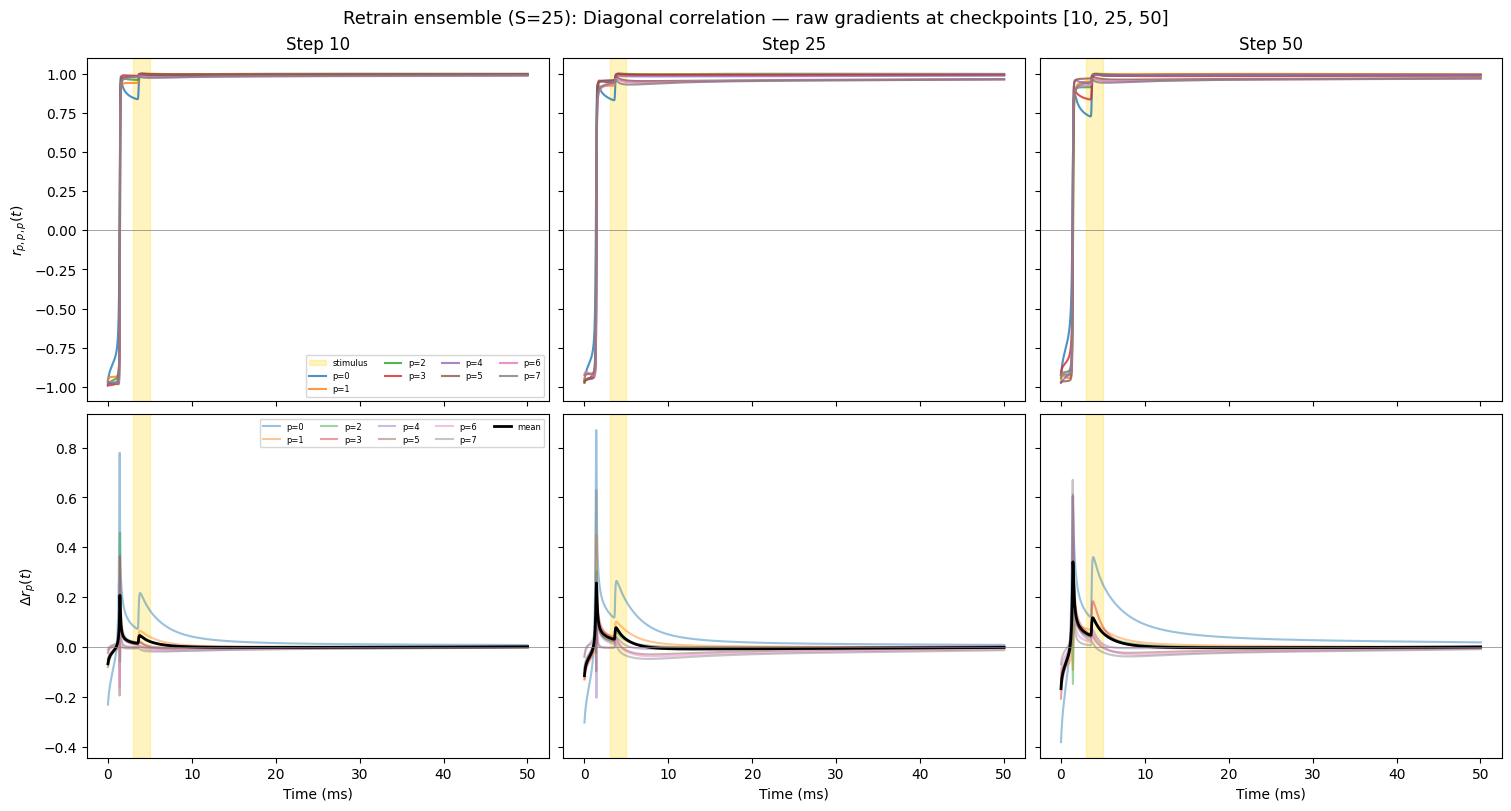

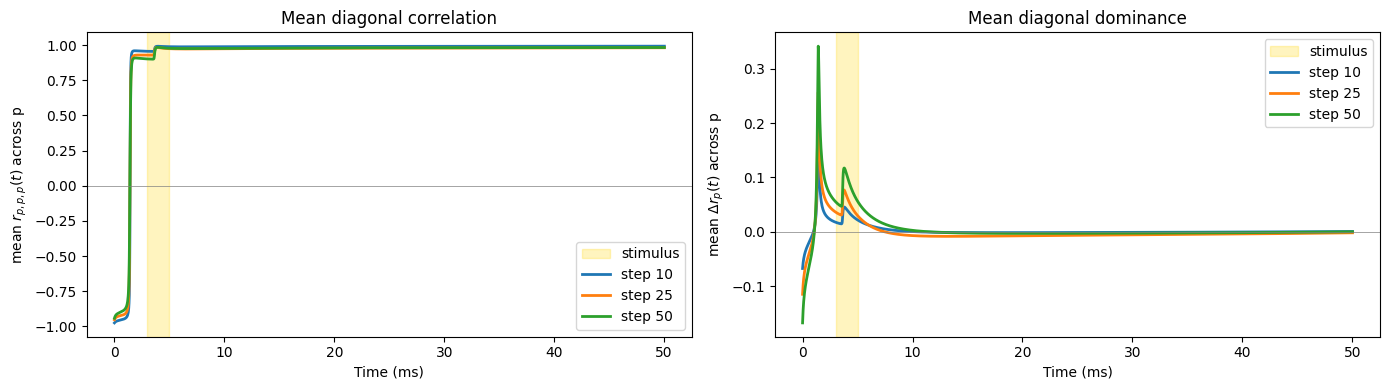

In [23]:
# ══════════════════════════════════════════════════════════════════════
# Deliverable A3 — Time-resolved correlation per checkpoint
# ══════════════════════════════════════════════════════════════════════
#
# For each checkpoint c and each (p, i, j):
#   r_{p,i,j}(t) = corr_s( ΔV_{s,p,j}(t),  g_{s,p,i} )
# ──────────────────────────────────────────────────────────────────────

B_mask_A3 = (t_arr < i_delay)
W_mask_A3 = (t_arr >= i_delay) & (t_arr <= i_delay + i_dur + 20.0)

def corr_over_seeds(X, y, eps=1e-12):
    """Pearson r between columns of X and scalar y, across rows (axis 0).
    X : (S, T)    y : (S,)    → (T,)
    """
    Xc = X - X.mean(axis=0, keepdims=True)
    yc = y - y.mean()
    num = (Xc * yc[:, None]).sum(axis=0)
    den = np.sqrt((Xc**2).sum(axis=0) * (yc**2).sum() + eps)
    return num / den

# ── Compute per-checkpoint: V0, G, R, r_diag, delta_r ────────────────
V0_ckpt     = {}   # {c: (S,8,8,T)}
G_ckpt      = {}   # {c: (S,8,8)}
R_ckpt      = {}   # {c: (8,8,8,T)}
r_diag_ckpt = {}   # {c: (8,T)}
delta_r_ckpt = {}  # {c: (8,T)}

for c in checkpoints:
    # baseline-subtract
    Vb = VALL_ckpt[c][:, :, :, B_mask_A3].mean(axis=3, keepdims=True)
    V0_ckpt[c] = VALL_ckpt[c] - Vb
    G_ckpt[c]  = GRADS_ckpt[c]

    # full correlation tensor
    R = np.zeros((Nsyn, Nsyn, Nsyn, T))
    for p in range(Nsyn):
        for i in range(Nsyn):
            g_pi = G_ckpt[c][:, p, i]
            for j in range(Nsyn):
                R[p, i, j, :] = corr_over_seeds(V0_ckpt[c][:, p, j, :], g_pi)
    R_ckpt[c] = R

    # diagonal curves
    rd = np.zeros((Nsyn, T))
    ro = np.zeros((Nsyn, T))
    for p in range(Nsyn):
        rd[p] = R[p, p, p, :]
        offs = [R[p, p, j, :] for j in range(Nsyn) if j != p]
        ro[p] = np.mean(np.stack(offs, 0), axis=0)
    r_diag_ckpt[c]  = rd
    delta_r_ckpt[c] = rd - ro

    print(f"  step {c:3d}: R shape {R.shape}, "
          f"peak diag r = {rd[:, W_mask_A3].max():.4f}")

# ─── Plot: Diagonal r(t) across checkpoints (side by side) ───────────
fig, axes = plt.subplots(2, n_ckpt, figsize=(5 * n_ckpt, 8),
                         sharex=True, sharey="row", constrained_layout=True)

for ci, c in enumerate(checkpoints):
    ax = axes[0, ci]
    ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25, label="stimulus")
    for p in range(Nsyn):
        ax.plot(t_arr, r_diag_ckpt[c][p], alpha=0.8, label=f"p={p}")
    ax.set_title(f"Step {c}")
    ax.axhline(0, color="grey", lw=0.5)
    if ci == 0:
        ax.set_ylabel(r"$r_{p,p,p}(t)$")
        ax.legend(fontsize=6, ncol=4)

    ax = axes[1, ci]
    ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25)
    for p in range(Nsyn):
        ax.plot(t_arr, delta_r_ckpt[c][p], alpha=0.45, label=f"p={p}")
    ax.plot(t_arr, delta_r_ckpt[c].mean(axis=0), "k", lw=2, label="mean")
    ax.axhline(0, color="grey", lw=0.5)
    ax.set_xlabel("Time (ms)")
    if ci == 0:
        ax.set_ylabel(r"$\Delta r_p(t)$")
        ax.legend(fontsize=6, ncol=5)

fig.suptitle(f"Retrain ensemble (S={S}): Diagonal correlation — raw gradients "
             f"at checkpoints {checkpoints}", fontsize=13)
plt.show()

# ─── Plot: Mean diagonal r(t) overlay across checkpoints ─────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=True)

ax = axes[0]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25, label="stimulus")
for c in checkpoints:
    ax.plot(t_arr, r_diag_ckpt[c].mean(axis=0), lw=2, label=f"step {c}")
ax.set_ylabel(r"mean $r_{p,p,p}(t)$ across p")
ax.set_xlabel("Time (ms)")
ax.set_title("Mean diagonal correlation")
ax.axhline(0, color="grey", lw=0.5)
ax.legend()

ax = axes[1]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25, label="stimulus")
for c in checkpoints:
    ax.plot(t_arr, delta_r_ckpt[c].mean(axis=0), lw=2, label=f"step {c}")
ax.set_ylabel(r"mean $\Delta r_p(t)$ across p")
ax.set_xlabel("Time (ms)")
ax.set_title("Mean diagonal dominance")
ax.axhline(0, color="grey", lw=0.5)
ax.legend()

plt.tight_layout(); plt.show()


  step  10: peak diag r (norm) = 0.9180
  step  25: peak diag r (norm) = 0.8670
  step  50: peak diag r (norm) = 0.8947


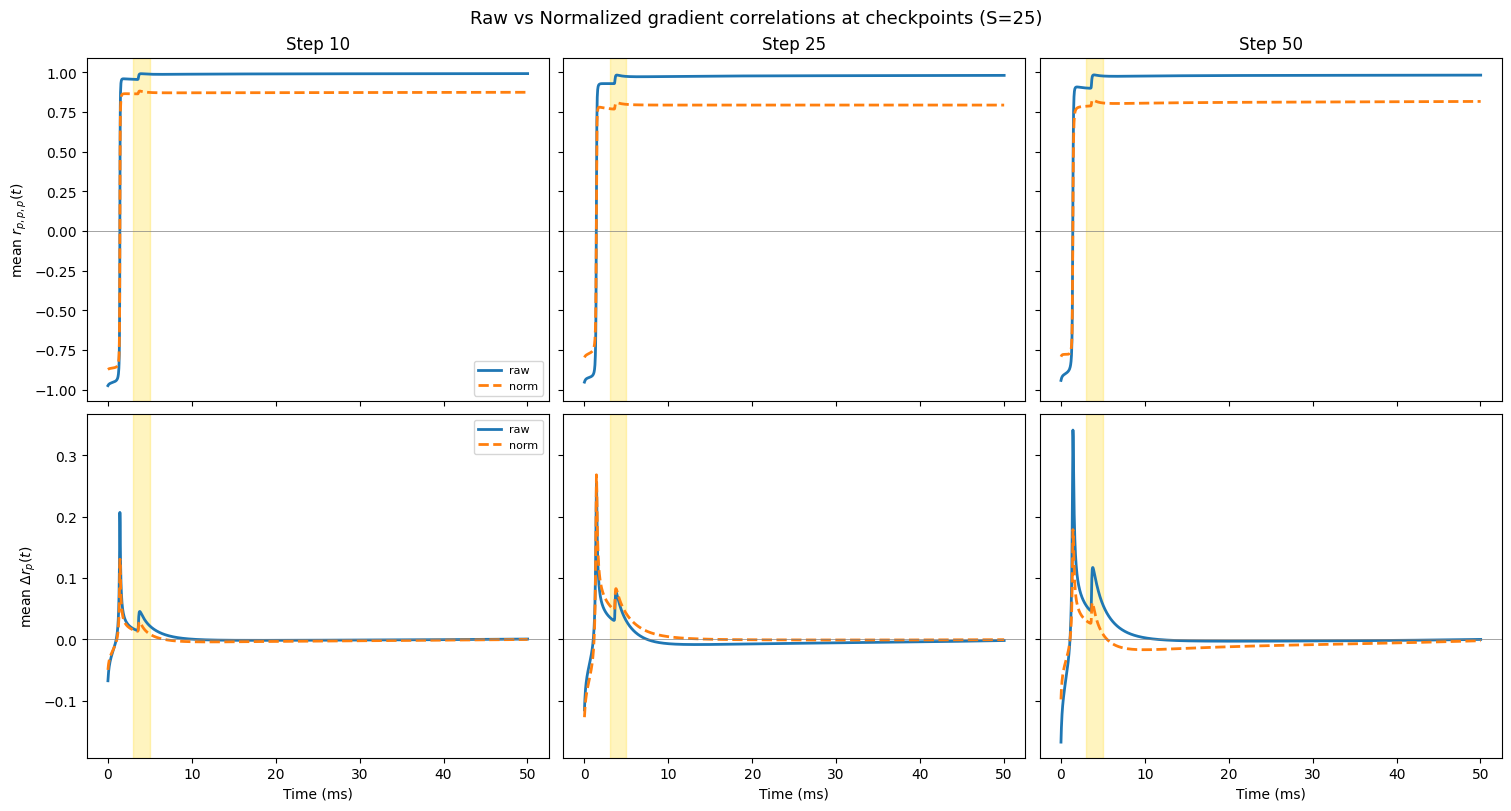

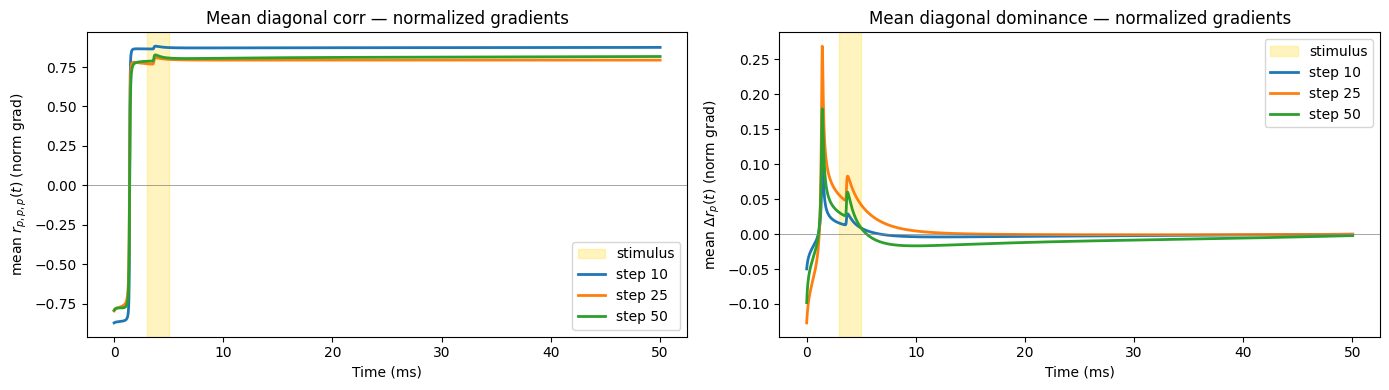

In [24]:
# ══════════════════════════════════════════════════════════════════════
# Deliverable A3 (cont.) — Normalized-gradient correlation per checkpoint
# ══════════════════════════════════════════════════════════════════════

eps_norm = 1e-12

r_diag_norm_ckpt  = {}
delta_r_norm_ckpt = {}

for c in checkpoints:
    Gn = G_ckpt[c] / (np.abs(G_ckpt[c]).sum(axis=-1, keepdims=True) + eps_norm)

    R_norm = np.zeros((Nsyn, Nsyn, Nsyn, T))
    for p in range(Nsyn):
        for i in range(Nsyn):
            g_pi = Gn[:, p, i]
            for j in range(Nsyn):
                R_norm[p, i, j, :] = corr_over_seeds(
                    V0_ckpt[c][:, p, j, :], g_pi)

    rd = np.zeros((Nsyn, T))
    ro = np.zeros((Nsyn, T))
    for p in range(Nsyn):
        rd[p] = R_norm[p, p, p, :]
        offs = [R_norm[p, p, j, :] for j in range(Nsyn) if j != p]
        ro[p] = np.mean(np.stack(offs, 0), axis=0)
    r_diag_norm_ckpt[c]  = rd
    delta_r_norm_ckpt[c] = rd - ro

    print(f"  step {c:3d}: peak diag r (norm) = {rd[:, W_mask_A3].max():.4f}")

# ─── Plot: Raw vs Normalized diagonal r(t) at each checkpoint ────────
fig, axes = plt.subplots(2, n_ckpt, figsize=(5 * n_ckpt, 8),
                         sharex=True, sharey="row", constrained_layout=True)

for ci, c in enumerate(checkpoints):
    ax = axes[0, ci]
    ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25)
    ax.plot(t_arr, r_diag_ckpt[c].mean(0), lw=2, label="raw")
    ax.plot(t_arr, r_diag_norm_ckpt[c].mean(0), lw=2, ls="--", label="norm")
    ax.set_title(f"Step {c}")
    ax.axhline(0, color="grey", lw=0.5)
    if ci == 0:
        ax.set_ylabel(r"mean $r_{p,p,p}(t)$")
        ax.legend(fontsize=8)

    ax = axes[1, ci]
    ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25)
    ax.plot(t_arr, delta_r_ckpt[c].mean(0), lw=2, label="raw")
    ax.plot(t_arr, delta_r_norm_ckpt[c].mean(0), lw=2, ls="--", label="norm")
    ax.axhline(0, color="grey", lw=0.5)
    ax.set_xlabel("Time (ms)")
    if ci == 0:
        ax.set_ylabel(r"mean $\Delta r_p(t)$")
        ax.legend(fontsize=8)

fig.suptitle(f"Raw vs Normalized gradient correlations at checkpoints "
             f"(S={S})", fontsize=13)
plt.show()

# ─── Plot: Overlay checkpoints for normalized grads ───────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=True)

ax = axes[0]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25, label="stimulus")
for c in checkpoints:
    ax.plot(t_arr, r_diag_norm_ckpt[c].mean(0), lw=2, label=f"step {c}")
ax.set_ylabel(r"mean $r_{p,p,p}(t)$ (norm grad)")
ax.set_xlabel("Time (ms)")
ax.set_title("Mean diagonal corr — normalized gradients")
ax.axhline(0, color="grey", lw=0.5); ax.legend()

ax = axes[1]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25, label="stimulus")
for c in checkpoints:
    ax.plot(t_arr, delta_r_norm_ckpt[c].mean(0), lw=2, label=f"step {c}")
ax.set_ylabel(r"mean $\Delta r_p(t)$ (norm grad)")
ax.set_xlabel("Time (ms)")
ax.set_title("Mean diagonal dominance — normalized gradients")
ax.axhline(0, color="grey", lw=0.5); ax.legend()

plt.tight_layout(); plt.show()


QUANTITATIVE SUMMARY — Retrain ensemble  (S=25, steps=50, lr=0.05, ckpts=[10, 25, 50])
Analysis window W: [3.0, 25.0] ms  (881 timepoints)

  Ckpt     peak r_diag     peak r_norm     mean Δr   mean Δr_norm   probe loss
--------------------------------------------------------------------------------
    10  0.9938±0.0064  0.8894±0.0413      0.0032        -0.0011     0.011245
    25  0.9866±0.0138  0.8207±0.0287     -0.0003         0.0090     0.002028
    50  0.9871±0.0135  0.8399±0.0286      0.0096        -0.0089     0.000155

── Checkpoint step=10 ──
    p    peak r   peak rn        Δr       Δrn        loss
    0    0.9996    0.7845    0.0455    0.0568    0.016507
    1    0.9998    0.9024    0.0088   -0.0286    0.017186
    2    0.9995    0.8808    0.0031   -0.0069    0.011570
    3    0.9985    0.9113   -0.0005   -0.0065    0.011626
    4    0.9946    0.9110   -0.0035   -0.0077    0.009610
    5    0.9900    0.9180   -0.0045   -0.0019    0.008687
    6    0.9835    0.8925   -0.0111  

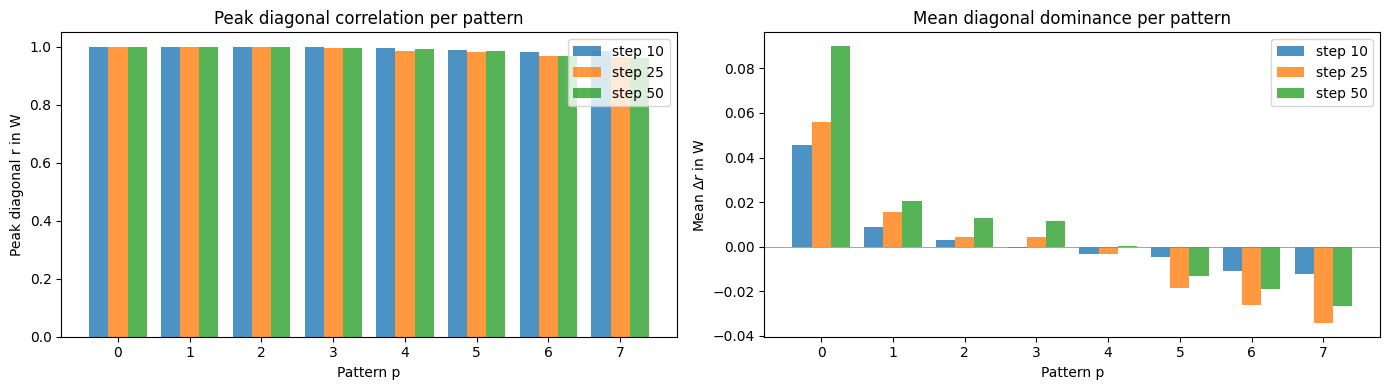

In [25]:
# ══════════════════════════════════════════════════════════════════════
# Deliverable A3 — Quantitative summary per checkpoint
# ══════════════════════════════════════════════════════════════════════

W_quant = W_mask_A3

print("=" * 100)
print(f"QUANTITATIVE SUMMARY — Retrain ensemble  "
      f"(S={S}, steps={n_steps_train}, lr={train_lr}, ckpts={checkpoints})")
print("=" * 100)
print(f"Analysis window W: [{i_delay:.1f}, {i_delay + i_dur + 20.0:.1f}] ms  "
      f"({W_quant.sum()} timepoints)\n")

# ── Per-checkpoint table ──────────────────────────────────────────────
rows = []
for c in checkpoints:
    pr  = r_diag_ckpt[c][:, W_quant].max(axis=1)        # (8,) peak per p
    prn = r_diag_norm_ckpt[c][:, W_quant].max(axis=1)
    mdr  = delta_r_ckpt[c][:, W_quant].mean(axis=1)
    mdrn = delta_r_norm_ckpt[c][:, W_quant].mean(axis=1)
    ml   = LOSS_ckpt[c].mean(axis=0)                     # (8,) mean across seeds

    rows.append(dict(
        c=c,
        peak_r_mean=pr.mean(), peak_r_std=pr.std(),
        peak_rn_mean=prn.mean(), peak_rn_std=prn.std(),
        mean_dr=mdr.mean(), mean_drn=mdrn.mean(),
        mean_loss=ml.mean(),
    ))

print(f"{'Ckpt':>6}  {'peak r_diag':>14}  {'peak r_norm':>14}  "
      f"{'mean Δr':>10}  {'mean Δr_norm':>13}  {'probe loss':>11}")
print("-" * 80)
for r in rows:
    print(f"{r['c']:>6}  "
          f"{r['peak_r_mean']:>6.4f}±{r['peak_r_std']:.4f}  "
          f"{r['peak_rn_mean']:>6.4f}±{r['peak_rn_std']:.4f}  "
          f"{r['mean_dr']:>10.4f}  {r['mean_drn']:>13.4f}  "
          f"{r['mean_loss']:>11.6f}")
print("=" * 80)

# ── Per-pattern detail at each checkpoint ─────────────────────────────
for c in checkpoints:
    print(f"\n── Checkpoint step={c} ──")
    print(f"  {'p':>3}  {'peak r':>8}  {'peak rn':>8}  "
          f"{'Δr':>8}  {'Δrn':>8}  {'loss':>10}")
    for p in range(Nsyn):
        pr_p  = r_diag_ckpt[c][p, W_quant].max()
        prn_p = r_diag_norm_ckpt[c][p, W_quant].max()
        dr_p  = delta_r_ckpt[c][p, W_quant].mean()
        drn_p = delta_r_norm_ckpt[c][p, W_quant].mean()
        ml_p  = LOSS_ckpt[c][:, p].mean()
        print(f"  {p:>3}  {pr_p:>8.4f}  {prn_p:>8.4f}  "
              f"{dr_p:>8.4f}  {drn_p:>8.4f}  {ml_p:>10.6f}")

# ── Learned gS summary at last checkpoint ─────────────────────────────
c_last = checkpoints[-1]
print(f"\nLearned gS at step {c_last} across {S} seeds:")
print(f"{'Syn':>5}  {'gS_true':>10}  {'mean':>10}  {'std':>10}  "
      f"{'min':>10}  {'max':>10}")
print("-" * 60)
for i in range(Nsyn):
    vals = gS_ckpt[c_last][:, i]
    print(f"{i:>5}  {float(gS_true[i]):>10.2e}  "
          f"{vals.mean():>10.2e}  {vals.std():>10.2e}  "
          f"{vals.min():>10.2e}  {vals.max():>10.2e}")
print("=" * 60)

# ── Bar chart: peak diag corr per checkpoint ──────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
x = np.arange(Nsyn)
w = 0.8 / n_ckpt

for ci, c in enumerate(checkpoints):
    pr = r_diag_ckpt[c][:, W_quant].max(axis=1)
    dr = delta_r_ckpt[c][:, W_quant].mean(axis=1)
    axes[0].bar(x + (ci - n_ckpt/2 + 0.5) * w, pr, w,
                label=f"step {c}", alpha=0.8)
    axes[1].bar(x + (ci - n_ckpt/2 + 0.5) * w, dr, w,
                label=f"step {c}", alpha=0.8)

axes[0].set_xlabel("Pattern p"); axes[0].set_ylabel("Peak diagonal r in W")
axes[0].set_title("Peak diagonal correlation per pattern"); axes[0].set_xticks(x)
axes[0].legend()
axes[1].set_xlabel("Pattern p"); axes[1].set_ylabel(r"Mean $\Delta r$ in W")
axes[1].set_title("Mean diagonal dominance per pattern"); axes[1].set_xticks(x)
axes[1].legend(); axes[1].axhline(0, color="grey", lw=0.5)

plt.tight_layout(); plt.show()
